In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchinfo import summary as Model_Summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchvision

In [35]:
Device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [36]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.padding1 = nn.ZeroPad2d(1)
        self.fc1 = nn.Linear(64*2*2, 64)             
        self.fc2 = nn.Linear(64, 10)                  

    def forward(self, x):
        x = self.padding1(x)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64*2*2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

model = CNN()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 74954


In [37]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


for epoch in range(5): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Print every 1000 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 1000:.3f}")
            running_loss = 0.0

print("Finished Training")


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

[1, 1000] loss: 2.300


KeyboardInterrupt: 


InceptionV1 from scratch

In [38]:
class ConvBlock(nn.Module):
    def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size, stride=Stride, padding=Padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
        self.Activ_Func = nn.ReLU()
   
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Batch_Norm(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        
        return Tensor_Path

Testing Convolution Block

In [39]:
Random_Tensor = torch.randn(5, 3, 224, 224) #Санамсаргүй байдлаар Тенсорыг үүсгэв.
Test_ConvBlock = ConvBlock(In_Channels=3, Out_Channels=128, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
print(Test_ConvBlock(Random_Tensor).shape)

torch.Size([5, 128, 224, 224])


Building Inception Block

In [40]:
class InceptionBlock(nn.Module):
    def __init__(self,In_Channels, Num_Of_Filters_1x1, Num_Of_Filters_3x3, Num_Of_Filters_5x5, Num_Of_Filters_3x3_Reduce,Num_Of_Filters_5x5_Reduce, Pooling):
        super(InceptionBlock, self).__init__()
        self.Block_1 = nn.Sequential(ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_1x1, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)))
        
        self.Block_2 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_3x3_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_3x3_Reduce, Out_Channels= Num_Of_Filters_3x3, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        )
        
        self.Block_3 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_5x5_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_5x5_Reduce, Out_Channels= Num_Of_Filters_5x5, Kernel_Size=(5,5), Stride=(1,1), Padding=(2,2))
        )
        
        self.Block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            ConvBlock(In_Channels=In_Channels, Out_Channels=Pooling, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        )
    def forward(self, Tensor_Path):
        First_Block_Out = self.Block_1(Tensor_Path)
        Second_Block_Out = self.Block_2(Tensor_Path)
        Third_Block_Out = self.Block_3(Tensor_Path)
        Fourth_Block_Out = self.Block_4(Tensor_Path)
        
        Concatenated_Outputs = torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1) #dim=1 because we want to concatenate in the depth dimension
        return Concatenated_Outputs

Test the Inception Block

In [41]:
class Auxiliary_Classifier(nn.Module):
    def __init__(self, In_Channels, Num_Classes):
        super(Auxiliary_Classifier, self).__init__()
        self.Adaptive_AvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.Conv = nn.Conv2d(in_channels= In_Channels, out_channels=128, kernel_size=(1,1), stride=(1,1), padding=(0,0))
        self.Activ_Func = nn.ReLU()
        self.FC_1 = nn.Linear(in_features=2048, out_features=1024) 
        self.DropOut = nn.Dropout(p=0.7) 
        self.FC_2 = nn.Linear(in_features=1024, out_features= Num_Classes)
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Adaptive_AvgPool(Tensor_Path)
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.FC_1(Tensor_Path)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC_2(Tensor_Path)
        
        return Tensor_Path

In [42]:
class InceptionNet_V1(nn.Module):
    def __init__(self, Out_Classes):
        super(InceptionNet_V1, self).__init__()
        self.Conv_1 = ConvBlock(In_Channels=3, Out_Channels=64, Kernel_Size=(7,7), Stride=(2,2), Padding=(3,3))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Conv_2 = ConvBlock(In_Channels=64, Out_Channels=64, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        self.Conv_3 = ConvBlock(In_Channels=64, Out_Channels=192, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_3a = InceptionBlock(In_Channels=192, Num_Of_Filters_1x1=64, Num_Of_Filters_3x3=128
                                          , Num_Of_Filters_5x5=32, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=32)
        
        self.Inception_3b = InceptionBlock(In_Channels=256, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=192
                                          , Num_Of_Filters_5x5=96, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)
        
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_4a = InceptionBlock(In_Channels=480, Num_Of_Filters_1x1=192, Num_Of_Filters_3x3=208
                                          , Num_Of_Filters_5x5=48, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=64)
        
        self.Inception_4b = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=160, Num_Of_Filters_3x3=224
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=112, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
        
        self.Inception_4c = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=256
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
       
        self.Inception_4d = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=112, Num_Of_Filters_3x3=288
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=144, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64) 
        
        self.Inception_4e = InceptionBlock(In_Channels=528, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_5a = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.Inception_5b = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=384, Num_Of_Filters_3x3=384
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=192, 
                                           Num_Of_Filters_5x5_Reduce=48, Pooling=128) 
        
        self.AvgPool_1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.DropOut = nn.Dropout(p=0.4)
        self.FC = nn.Linear(in_features=1024, out_features=Out_Classes)
        
        self.Auxiliary_4a = Auxiliary_Classifier(In_Channels=512, Num_Classes=Out_Classes)
        self.Auxiliary_4d = Auxiliary_Classifier(In_Channels=528, Num_Classes=Out_Classes)
        
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv_1(Tensor_Path)
        Tensor_Path = self.MaxPool_1(Tensor_Path)
        Tensor_Path = self.Conv_2(Tensor_Path)
        Tensor_Path = self.Conv_3(Tensor_Path)
        Tensor_Path = self.MaxPool_2(Tensor_Path)
        Tensor_Path = self.Inception_3a(Tensor_Path)
        Tensor_Path = self.Inception_3b(Tensor_Path)
        Tensor_Path = self.MaxPool_3(Tensor_Path)
        Tensor_Path = self.Inception_4a(Tensor_Path)
        Auxiliary_1 = self.Auxiliary_4a(Tensor_Path)
        Tensor_Path = self.Inception_4b(Tensor_Path)
        Tensor_Path = self.Inception_4c(Tensor_Path)
        Tensor_Path = self.Inception_4d(Tensor_Path)
        Auxiliary_2 = self.Auxiliary_4d(Tensor_Path)
        Tensor_Path = self.Inception_4e(Tensor_Path)
        Tensor_Path = self.MaxPool_4(Tensor_Path)
        Tensor_Path = self.Inception_5a(Tensor_Path)
        Tensor_Path = self.Inception_5b(Tensor_Path)
        Tensor_Path = self.AvgPool_1(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC(Tensor_Path)
        
        return Tensor_Path, Auxiliary_1, Auxiliary_2

In [43]:
Random_Tensor_4 = torch.randn(51, 3, 224, 224) # Санамсаргүй байдлаар Тенсор үүсгэж моделыг шалгах нь
Network_Outputs = InceptionNet_V1(Out_Classes=10)
Model_Summary(Network_Outputs, Random_Tensor_4.shape)

Layer (type:depth-idx)                   Output Shape              Param #
InceptionNet_V1                          [51, 10]                  --
├─ConvBlock: 1-1                         [51, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [51, 64, 112, 112]        9,472
│    └─BatchNorm2d: 2-2                  [51, 64, 112, 112]        128
│    └─ReLU: 2-3                         [51, 64, 112, 112]        --
├─MaxPool2d: 1-2                         [51, 64, 56, 56]          --
├─ConvBlock: 1-3                         [51, 64, 56, 56]          --
│    └─Conv2d: 2-4                       [51, 64, 56, 56]          4,160
│    └─BatchNorm2d: 2-5                  [51, 64, 56, 56]          128
│    └─ReLU: 2-6                         [51, 64, 56, 56]          --
├─ConvBlock: 1-4                         [51, 192, 56, 56]         --
│    └─Conv2d: 2-7                       [51, 192, 56, 56]         110,784
│    └─BatchNorm2d: 2-8                  [51, 192, 56, 56]         384
│

In [44]:
def Train_Validate_Model(Model, Train_Loader, Val_Loader, Num_Of_Train_Samples, Num_Of_Val_Samples, Criterion,Optimizer, Num_Epochs):
     
    Train_Loss_History = []
    Train_Accuracy_History = []
    Val_Loss_History = []
    Val_Accuracy_History = []
    for epoch in tqdm(range(Num_Epochs)):
        Num_Of_Predicted_Correctly = 0
        Train_Cummulative_Loss = 0 
        for batch_samples,targets in Train_Loader:
            batch_samples = batch_samples.to(device=Device)
            targets = targets.to(device=Device)
            
            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)
            
            Network_Loss = Criterion(Network_Predictions, targets)
            Aux_1_Loss = Criterion(Aux_1_Predictions, targets)
            Aux_2_Loss = Criterion(Aux_2_Predictions, targets)
            
            Main_Loss = Network_Loss + (0.3 * Aux_1_Loss) + (0.3 * Aux_2_Loss)
            
            Optimizer.zero_grad()
            Main_Loss.backward()
            Optimizer.step()
            
            _, Train_Samples_Predictions = Network_Predictions.max(1)
            Train_Samples_Predictions = Train_Samples_Predictions.to(device=Device)
            Num_Of_Predicted_Correctly += (Train_Samples_Predictions == targets).float().sum().item()
            Train_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
        Train_Cummulative_Loss /= Num_Of_Train_Samples
        Train_Loss_History.append(Train_Cummulative_Loss)
        Train_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Train_Samples
        Train_Accuracy_History.append(Train_Accuracy)
    
    
        Num_Of_Predicted_Correctly = 0
        with torch.no_grad(): 
            Val_Cummulative_Loss = 0
            for batch_samples,targets in Val_Loader:
                batch_samples = batch_samples.to(device=Device)
                targets = targets.to(device=Device)

                Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)

                Network_Loss = Criterion(Network_Predictions, targets)
                Aux_1_Loss = Criterion(Aux_1_Predictions, targets)
                Aux_2_Loss = Criterion(Aux_2_Predictions, targets)

                Main_Loss = Network_Loss + (0.3 * Aux_1_Loss) + (0.3 * Aux_2_Loss)

                _, Val_Samples_Predictions = Network_Predictions.max(1)
                Val_Samples_Predictions = Val_Samples_Predictions.to(device=Device)
                Num_Of_Predicted_Correctly += (Val_Samples_Predictions == targets).float().sum().item()
                Val_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
            Val_Cummulative_Loss /= Num_Of_Val_Samples
            Val_Loss_History.append(Val_Cummulative_Loss)
            Val_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Val_Samples
            Val_Accuracy_History.append(Val_Accuracy)


            print("Epoch:", epoch, " ", "train-loss:", Train_Cummulative_Loss 
                 , " ", "train-acc:", Train_Accuracy, " ", "val-loss:", Val_Cummulative_Loss, " ",
                 "val-acc:", Val_Accuracy)
    torch.save(Model.state_dict(), "InceptionNet_Model")
    return Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History

In [45]:
def Show_Image(Sample, Target):
    # this dictionary is to convert target index to its actual name when plotting image
    CIFAR_Targets= {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
                   5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    plt.imshow(Sample)
    plt.title(CIFAR_Targets[Target])
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Image shape of a random sample image : (3, 32, 32)



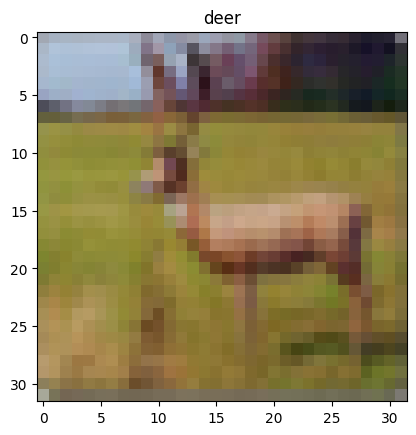

In [46]:
def CIFAR_DataLoader(Num_Of_Train_Samples, Num_Of_Val_Samples, Batch_Size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    CIFAR_Train_set = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
    CIFAR_Test_set = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
    
   
    Train_Samples, Validation_Samples = random_split(CIFAR_Train_set, (Num_Of_Train_Samples, Num_Of_Val_Samples))
    
   
    Train_Loader = DataLoader(Train_Samples,batch_size= Batch_Size, shuffle=True)
    Val_Loader = DataLoader(Validation_Samples,batch_size= Batch_Size, shuffle=True)
    Test_Loader = DataLoader(CIFAR_Test_set, batch_size= Batch_Size, shuffle=True)
    print("Image shape of a random sample image : {}".format(Train_Samples[0][0].numpy().shape), end = '\n\n')

    Random_Sample_Index = np.random.randint(0,Num_Of_Train_Samples+Num_Of_Val_Samples)
    Sample = np.array(CIFAR_Train_set.data)[Random_Sample_Index]
    Target = np.array(CIFAR_Train_set.targets)[Random_Sample_Index]
    Show_Image(Sample, Target)
    
    return Train_Loader, Val_Loader, Test_Loader

Train_Set, Validation_Set, Test_Set = CIFAR_DataLoader(Num_Of_Train_Samples=45000,Num_Of_Val_Samples= 5000, Batch_Size=128)

In [47]:
def Plot_Model_History(Train_Accuracy_History , Val_Accuracy_History, Train_Loss_History, Val_Loss_History):
    # plot Accuracy
    plt.plot(Train_Accuracy_History, marker='o')
    plt.plot(Val_Accuracy_History, marker='o')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plot Loss
    plt.plot(Train_Loss_History, marker='8')
    plt.plot(Val_Loss_History, marker='8')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [48]:
def Propagate_Network():
    Inception_Model = InceptionNet_V1(Out_Classes=10).to(device=Device)
    Cross_Entropy_Criterion = nn.CrossEntropyLoss()
    Adam_Optimizer = optim.Adam(Inception_Model.parameters(), lr=0.001)
    Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History = Train_Validate_Model(Model = Inception_Model, Train_Loader = Train_Set,Val_Loader = Validation_Set,Num_Of_Train_Samples = 45000,
                         Num_Of_Val_Samples = 5000,Criterion = Cross_Entropy_Criterion,Optimizer = Adam_Optimizer,Num_Epochs = 100)
    
    Plot_Model_History( Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History)
Propagate_Network()

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 